rec_loss =10* reconstruction_loss(generated_imgs, imgs)

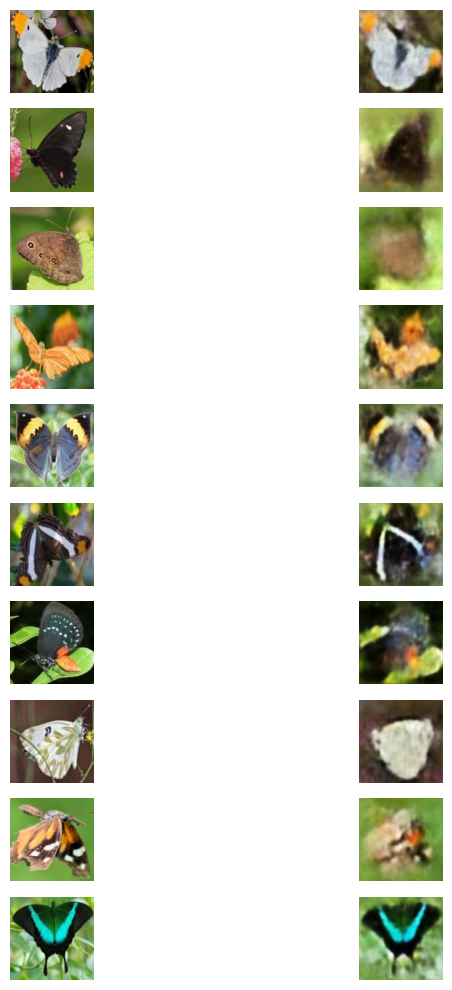

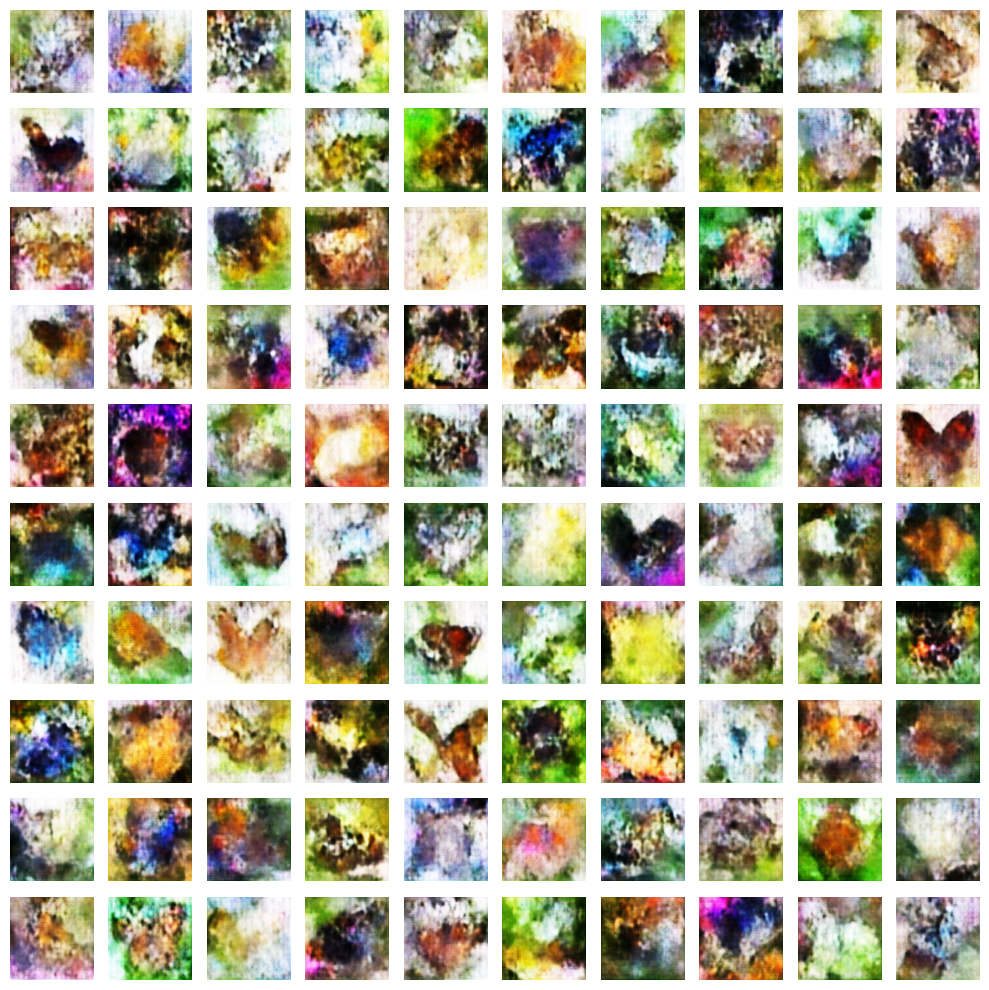

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 180
learning_rate = 0.0002
epochs = 200

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(128*2),
            nn.ReLU(),
            nn.Conv2d(128*2, 128*4, 4, stride=2, padding=1),
            nn.BatchNorm2d(128*4),
            nn.ReLU(),
            nn.Conv2d(128*4, 128*8, 4, stride=4, padding=0),
            nn.BatchNorm2d(128*8),
            nn.ReLU(),
            nn.Conv2d(128*8, 128*16, 4, stride=4, padding=0),
            nn.BatchNorm2d(128*16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*16, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Decoder 
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*16*4*4),

            nn.ReLU(),
            nn.Unflatten(1, (128*16,4,4)),
            nn.ConvTranspose2d(128*16, 128*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(128*8),
            nn.ReLU(),
            nn.ConvTranspose2d(128*8, 128*4, 4, stride=2, padding=1),
            nn.BatchNorm2d(128*4),
            nn.ReLU(),
            nn.ConvTranspose2d(128*4, 128*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(128*2),
            nn.ReLU(),
            nn.ConvTranspose2d(128*2, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.decoder(z).view(-1, 3, 128, 128)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(latent_dim, 128*16),

            nn.LeakyReLU(0.2,False),
            nn.Linear(128*16, 128*8),
            nn.LeakyReLU(0.2,False),
            nn.Linear(128*8, 128*4),

            nn.LeakyReLU(0.2,False),
            nn.Linear(128*4, 128*2),

            nn.LeakyReLU(0.2,False),
            nn.Linear(128*2, 128),

            nn.LeakyReLU(0.2,False),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.discriminator(z)

encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)

reconstruction_loss = nn.MSELoss()
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
optimizer_E = optim.Adam(encoder.parameters(), lr=learning_rate)  
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)


mean = np.zeros(latent_dim)
covariance = np.eye(latent_dim)

for epoch in range(epochs):
    for batch, data in enumerate(dataloader_butterfly):
        torch.autograd.set_detect_anomaly(True)
        imgs = data['image'].to(device)

        real_labels = torch.ones(imgs.size(0), 1, device=device)
        fake_labels = torch.zeros(imgs.size(0), 1, device=device)


        # ---------------------
        #  Train (Encoder + Decoder)
        # ---------------------
        optimizer_G.zero_grad()

        z_fake = encoder(imgs)
        generated_imgs = decoder(z_fake)

    
        rec_loss = reconstruction_loss(generated_imgs, imgs)
        rec_loss.backward(retain_graph=True) 
        optimizer_G.step() 

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        z_real = torch.tensor(np.random.multivariate_normal(mean,covariance,imgs.size(0)),dtype=torch.float).to(device) #torch.randn(imgs.size(0), latent_dim, device=device)

        d_loss_real = adversarial_loss(discriminator(z_real), real_labels)
        d_loss_fake = adversarial_loss(discriminator(z_fake.detach()), fake_labels)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Train Encoder with Adversarial Loss
        # ---------------------
        optimizer_E.zero_grad()

        adv_loss = adversarial_loss(discriminator(encoder(imgs)), real_labels)  # Avoid in-place issues here
        adv_loss.backward()

        optimizer_E.step() 

    if (epoch+1) % 10 == 0: 
        print(f"Epoch [{epoch+1}/{epochs}]  rec_loss - {rec_loss.item()}, adv_loss - {adv_loss.item()}")
        fig, axs = plt.subplots(10, 2, figsize=(10, 10))
        for data in dataloader_butterfly:
            img_orgs=data['image'].to(device)
            z = encoder(img_orgs)
            gen_imgs = decoder(z).detach().cpu()
            for i in range(10):
                    img_org=img_orgs[i].detach().cpu()
                    img_o = img_org.permute(1, 2, 0).detach().numpy()
                    min_val = img_o.min()
                    max_val = img_o.max()
                    normalized_img_o = (img_o - min_val) / (max_val - min_val)
                    img = gen_imgs[i].permute(1, 2, 0).detach().numpy()
                    min_val = img.min()
                    max_val = img.max()
                    normalized_img = (img - min_val) / (max_val - min_val)
                    
                    axs[i, 0].imshow(normalized_img_o)
                    axs[i, 0].axis('off')       
                    axs[i, 1].imshow(normalized_img)
                    axs[i, 1].axis('off')
            break
        plt.tight_layout()
        plt.show()   

        z = torch.tensor(np.random.multivariate_normal(mean,covariance,100),dtype=torch.float).to(device)
        with torch.no_grad():
            generated_img = decoder(z).detach().cpu()

        fig, axs = plt.subplots(10, 10, figsize=(10, 10))

        for i in range(10):
            for j in range(10):
                img = generated_img[i * 10 + j].permute(1, 2, 0).detach().numpy()
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val)
                
                axs[i, j].imshow(normalized_img)
                axs[i, j].axis('off')

        plt.tight_layout()
        plt.show()
        
        fid_value = calculate_fid_butterfly(decoder)
        print(f"FID Score at epoch {epoch+1}: {fid_value}")
    


